In [91]:
from sklearn import datasets
import seaborn as sns
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

sns.set()

## Spectral Clustering 

In this notebook, we go through the steps of Spectral Clustering on a dataset of concentric circles.

## Create the Dataset and Test on K-means

First, we create the dataset as follows and test the performance using a naive KMeans algorithm.

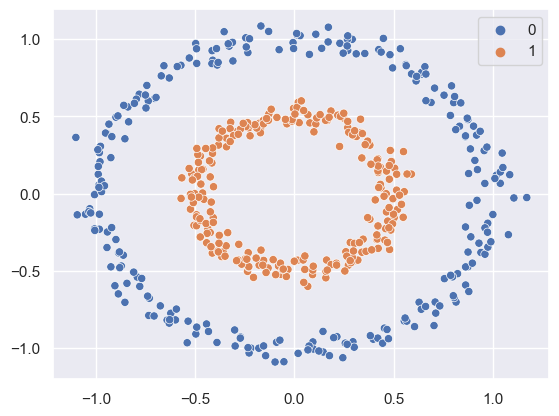

In [49]:
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)

X, y = noisy_circles

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

Here we try using KMeans to cluster the dataset:

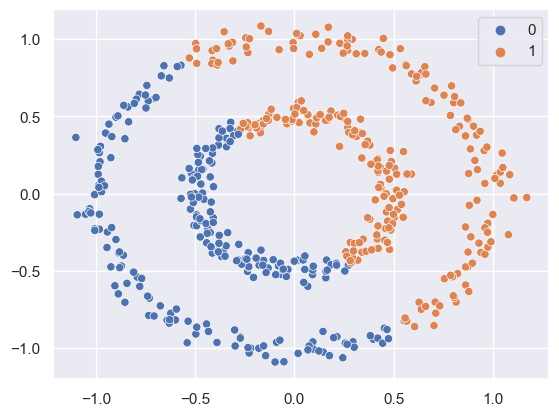

In [51]:
kmeans_naive_pred = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=kmeans_naive_pred);

As we can see, Kmeans performs very poorly on the dataset because it tries to separate the circles into two distinct Voronoi cells. However, the data is not separable in this fashion. Now we will try Spectral Clustering instead.

## Spectral Clustering

Step 1: Form an adjacency graph of all the points in $X$. There are two common methods to do this:

1. $\epsilon$-neighborhood: We choose a hyperparameter $\epsilon$ and a distance metric $d$. If $d(x_i, x_j) \leq \epsilon$, then form an edge between $x_i, x_j$. 
2. $k$-nearest neighbor. We choose a hyperparameter $k$ and a distance metric $d$. For each $x_i$, form an edge between $x_i, x_j$ if $x_j \in N_k(x_i)$, the set of $k$-nearest neighbors of $x_i$.

In the following code we use the `kneighbors_graph` function from sklearn to construct $W$, our weighted adjacency matrix. We use `n_neighbors = 10`, which means that we form an edge between each node and its 10 closest neighbors. The parameter `mode = 'distance'` means that we are weighting each connection by the Euclidean distance between the points. By default, the parameter `mode` is set to `connectivity`, which results in either 1 if a connection exists between $x_i, x_j$, else 0. 

For spectral clustering, we want to weight the adjacency matrix because our constructed graph will not be perfect. Because of the choice of $k$, we might form erroneous connections between clusters. However, we're hoping that these connections will be weak, meaning that they will have lower (or higher depending on how the function is implemented) weight than connections within the cluster.

In [16]:
W = kneighbors_graph(X, n_neighbors=10, mode='distance').toarray()
W.shape

(500, 500)

Step 2: Construct $G$, the degree matrix. This is the diagonal matrix formed by the row sums of $W$.

In [23]:
G = np.diag(W.sum(axis=1))
G.shape

(500, 500)

Step 3: Form the unnormalized Graph Laplacian $$L = G - W$$ 

By construction, $(1, 1, \dots, 1)^{\top}$ will be an eigenvector of $L$. However, it is important to note that in general, we don't consider this eigenvector because it is a linear combination of other more interesting eigenvectors.

The relevant result about Graph Laplacian is the following:

**The number of connected components in a graph is equal to the number of distinct eigenvectors corresponding to the eigenvalue 0.**

In [24]:
# graph laplacian

L = G - W

Step 4: Calculate the eigenvectors and eigenvalues of $L$, and order by eigenvalue. If we had perfect separation into connected components, the result above would tell us that we should expect 2 eigenvectors corresponding to zero.

Note that we're taking the real parts of the eigenvalues and eigenvectors here. If the solver was perfect, there would be no imaginary components because the Graph Laplacian is symmetric. But I'm guessing that the imaginary parts are pretty negligible in this scenario.

In [27]:
w, v = np.linalg.eig(L)
real_eigenvalues = np.real(w)
eigen_idx = np.argsort(np.real(w))

eigen_vectors = v[:, eigen_idx]
real_eigenvalues = real_eigenvalues[eigen_idx]

eigen_vectors.shape, real_eigenvalues.shape

However, because our graph is not constructed perfectly, we won't get two eigenvectors corresponding to zero exactly. But the cool thing is that if the number of erroneous connections is low, then the eigenvalues will be very close to zero. Since we are expecting two components here, if we plot the first 5 eigenvalues as below, we should see some sort of sharp cutoff at 2:

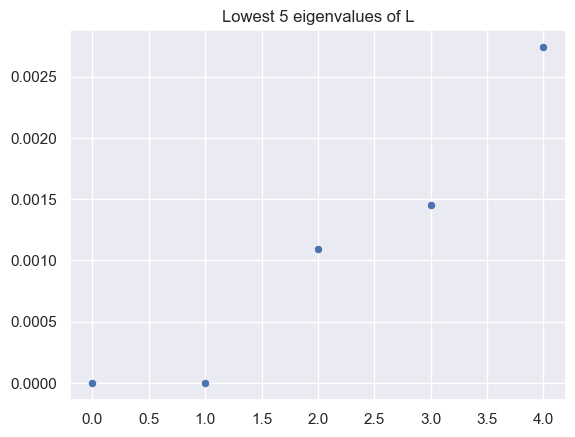

In [57]:
sns.scatterplot(real_eigenvalues[:5]).set_title('Lowest 5 eigenvalues of L');

As we can see from the output below, the first two eigenvalues are not exactly 0, but they are very close to it. In this scenario we are expecting two very low eigenvalues, but in general we can use such a plot to pick a cutoff $C$ that we will use for clustering. 

In [55]:
print(f'magnitude of two lowest eigenvalues: {real_eigenvalues[:2]}')

magnitude of two lowest eigenvalues: [3.71509023e-16 8.97410422e-16]


Step 5: Get the eigenvectors corresponding to the cutoff $C = 2$. This results in a matrix $T$ of shape $N \times C$. If we plot this matrix, we will see that the rows of $T$ perfectly separate the data into clusters.

<AxesSubplot: >

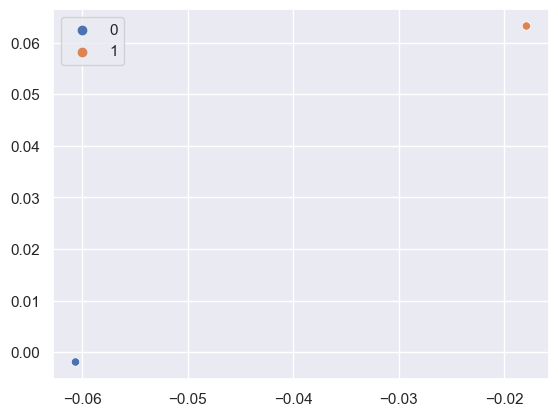

In [43]:
projection = eigen_vectors[:, :2].real
sns.scatterplot(x = projection[:, 0], y = projection[:, 1], hue=y)

It's magical that the rows of the truncated eigenvector matrix would give clean separation, but the intuition is that every eigenvector corresponding to zero is constant on a connected component, but has different values between connected components. The first eigenvector takes values of roughly either -0.0606 or -0.017. The second eigenvector takes values of roughly either 0.0632 or -0.0019. 

The binary value of the eigenvector tells whether the point is in a particular connected component or not. Thus the rows of the eigenvector matrix is an encoding that tells us which connected component each point is in. 

At this point, we can just do a KMeans on the rows to group the points into different connected components. As we can see below, this gives perfect separation of the points:

<AxesSubplot: >

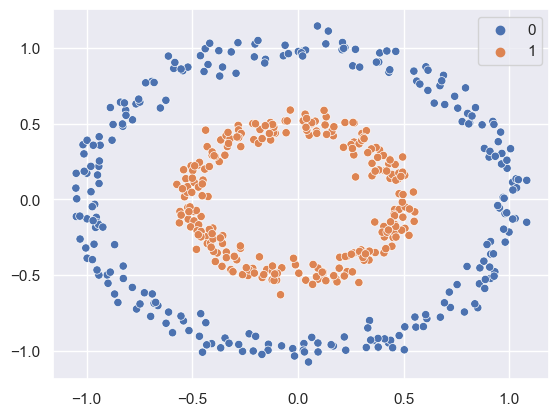

In [47]:
kmeans_pred = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(projection)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=kmeans_pred)

## Experiments on Noisier Data

This next section is entirely for fun, but let's try to see how spectral clustering would perform if we increase the noise levels in the data. First we should condense the above code into a useable class:

In [78]:
class SpectralClustering:
    def __init__(self, k, n_neighbors=10) -> None:
        self.k = k
        self.n_neighbors = n_neighbors

    def fit_predict(self, X: np.array) -> None:
        W = kneighbors_graph(X, n_neighbors=self.n_neighbors, mode='distance').toarray()
        G = np.diag(W.sum(axis=1))
        L = G - W

        w, v = np.linalg.eig(L)
        real_eigenvalues = np.real(w)
        eigen_idx = np.argsort(np.real(w))

        eigen_vectors = v[:, eigen_idx]
        real_eigenvalues = real_eigenvalues[eigen_idx]
        
        projection = eigen_vectors[:, :self.k].real
        kmeans_pred = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(projection)
        return kmeans_pred

## Noise = 0.05

This was the original case that we considered above:

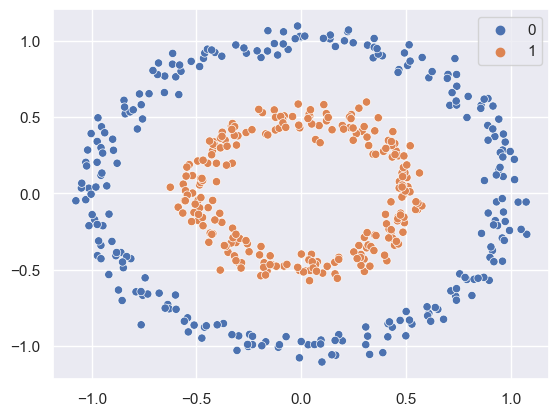

In [79]:
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)

X, y = noisy_circles

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

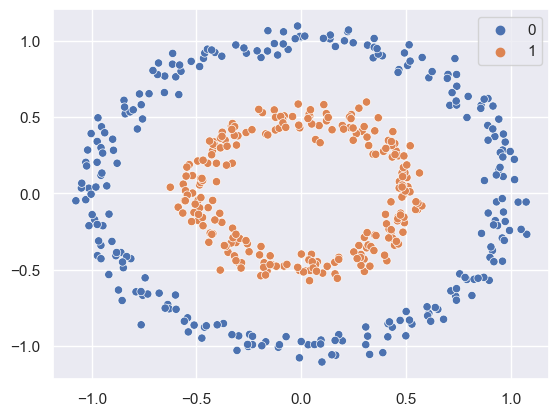

In [80]:
sc = SpectralClustering(2)

y_pred = sc.fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred);

## Noise = 0.1

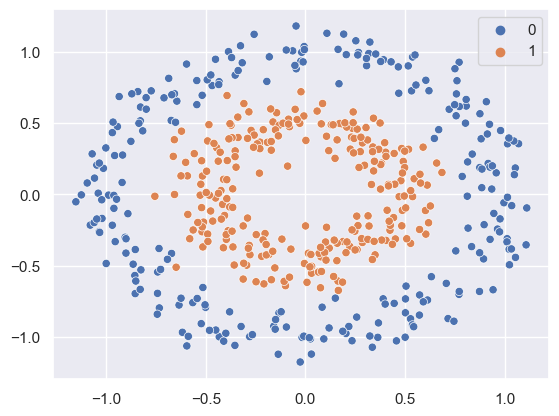

In [82]:
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.1)

X, y = noisy_circles

sns.scatterplot(x=X[:,0], y=X[:,1], hue=y);

If we increase the noise, then spectral clustering does pretty bad again, probably because it is only sensing one connected component.

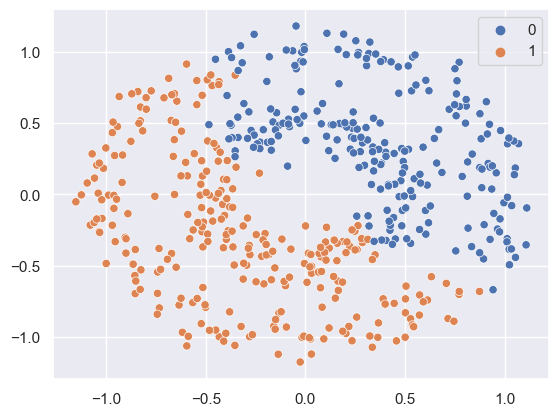

In [83]:
sc = SpectralClustering(2)

y_pred = sc.fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred);

If we reduce the number of neighbors, the clustering becomes cleaner:

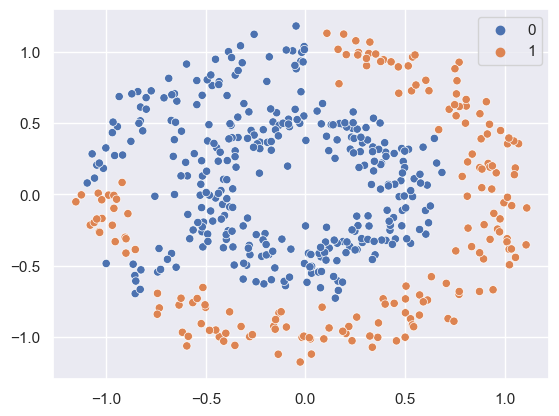

In [86]:
sc = SpectralClustering(2, n_neighbors=5)

y_pred = sc.fit_predict(X)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred);

However, reducing the number of neighbors past 5 does not improve the clustering much:

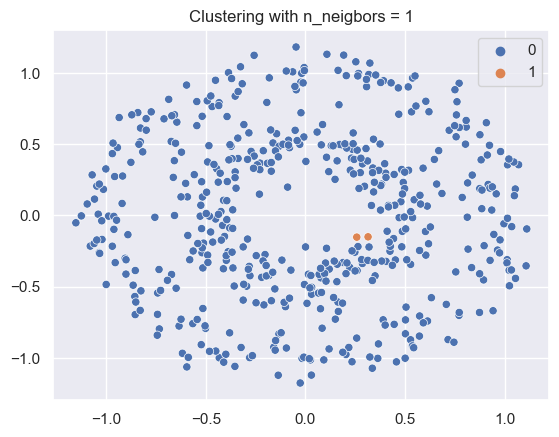

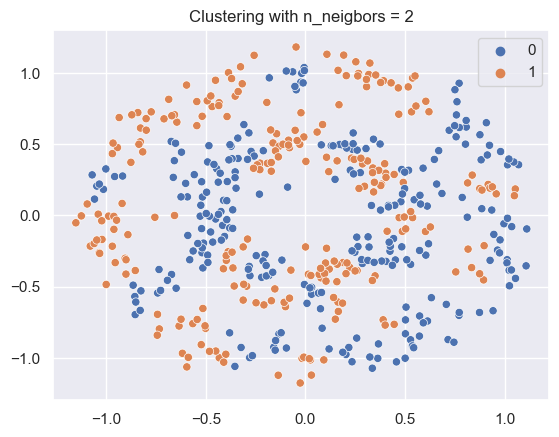

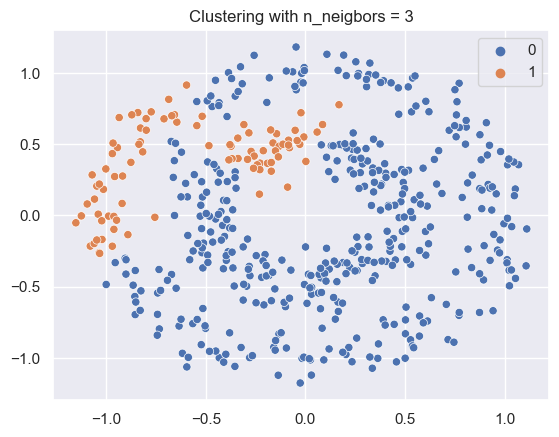

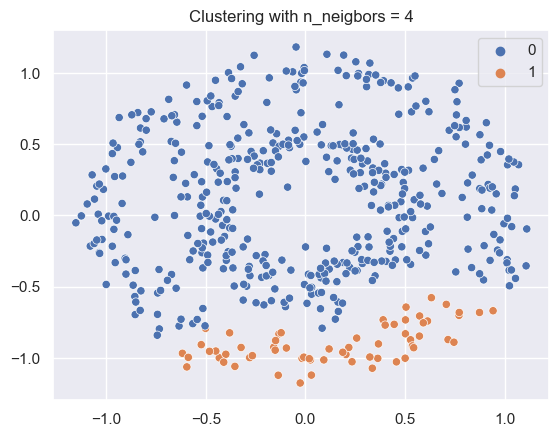

In [92]:
for n_neighbors in range(1, 5):
    sc = SpectralClustering(2, n_neighbors=n_neighbors)

    y_pred = sc.fit_predict(X)
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y_pred).set_title(f"Clustering with n_neigbors = {n_neighbors}");
    plt.show();